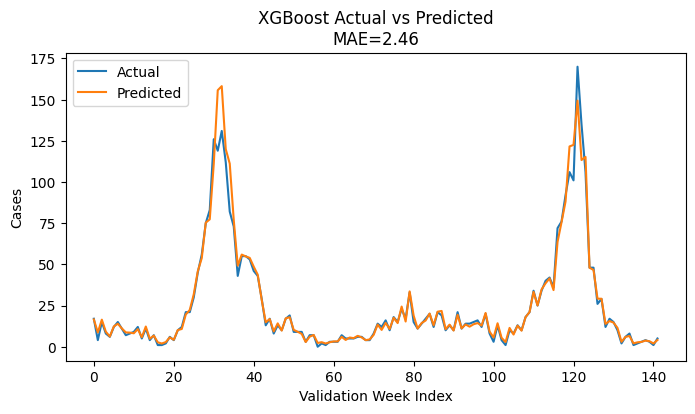

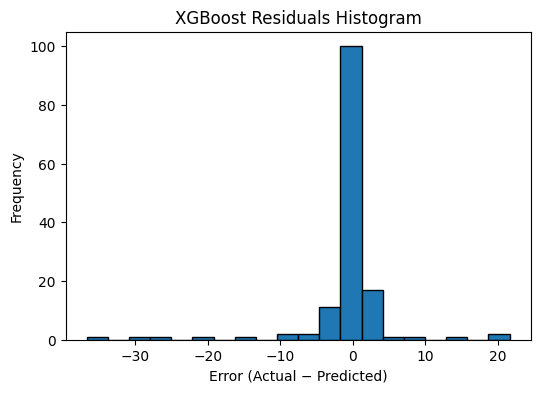

/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 1399.3190 - val_loss: 571.2394
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 360.1540 - val_loss: 372.4513
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 160.1125 - val_loss: 246.5615
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 165.7181 - val_loss: 242.9402
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 142.0392 - val_loss: 442.0628
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 119.5204 - val_loss: 359.0148
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 84.3134 - val_loss: 320.0839
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 81.8093 - val_loss: 258.2638
Epoch 9/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 57.0154 - val_loss: 205.2554
Epoch 10/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 56.7801 - val_loss: 244.3816
Epoch 11/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 32.1752 - val_loss: 252.5467
Epoch 12/30
35/35 ━━━━

1/5 ━━━━━━━━━━━━━━━━━━━━ 2s 500ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


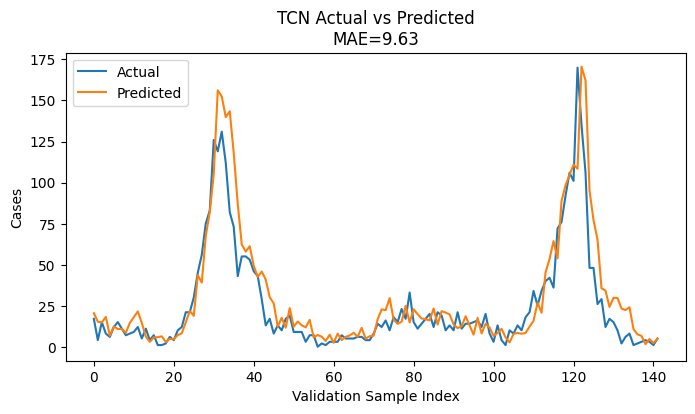

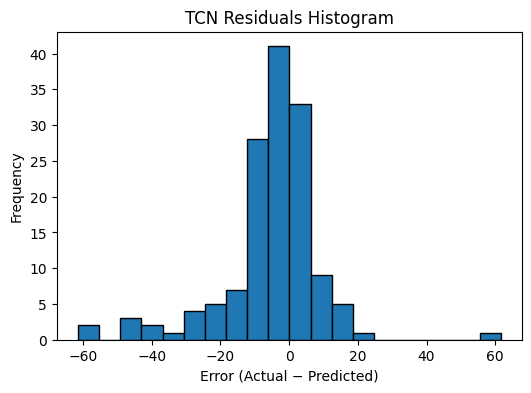

In [14]:
!pip install xgboost keras-tcn

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense
from tcn import TCN
import matplotlib.pyplot as plt

train_feat = pd.read_csv("dengue_features_train.csv")
train_lab  = pd.read_csv("dengue_labels_train.csv")
train = pd.merge(train_feat, train_lab, on=["city","year","weekofyear"])

sj = train[train.city == "sj"].reset_index(drop=True)
#
for lag in [1,2,3]:
    sj[f"cases_lag_{lag}"] = sj["total_cases"].shift(lag)
    sj[f"temp_lag_{lag}"]  = sj["reanalysis_avg_temp_k"].shift(lag)
sj["humidity_roll3"] = sj["reanalysis_specific_humidity_g_per_kg"].rolling(3).mean()
sj["sin_week"]       = np.sin(2 * np.pi * sj["weekofyear"]/52)
sj["cos_week"]       = np.cos(2 * np.pi * sj["weekofyear"]/52)
sj["temp_high"]      = (sj["reanalysis_avg_temp_k"] > 295).astype(int)
sj["humid_ndvi"]     = sj["reanalysis_specific_humidity_g_per_kg"] * sj["ndvi_ne"]
sj["case_growth"]    = sj["total_cases"].diff()

sj = sj.dropna().reset_index(drop=True)

feature_cols = [
    "cases_lag_1","cases_lag_2","cases_lag_3",
    "temp_lag_1","temp_lag_2","temp_lag_3",
    "humidity_roll3","sin_week","cos_week",
    "temp_high","humid_ndvi","case_growth"
]
X = sj[feature_cols].values
y = sj["total_cases"].values
#
n = len(sj)
split = int(n * 0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

imputer = SimpleImputer(strategy="mean")
scaler  = StandardScaler()
X_train_scaled = scaler.fit_transform(imputer.fit_transform(X_train))
X_val_scaled   = scaler.transform(imputer.transform(X_val))
#
xgb = XGBRegressor(
    n_estimators=200, learning_rate=0.05, max_depth=4,
    objective="reg:squarederror", random_state=42
)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_val_scaled)
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)

# C
plt.figure(figsize=(8,4))
plt.plot(y_val, label="Actual")
plt.plot(y_pred_xgb, label="Predicted")
plt.title(f"XGBoost Actual vs Predicted\nMAE={mae_xgb:.2f}")
plt.xlabel("Validation Week Index")
plt.ylabel("Cases")
plt.legend()
plt.show()

# R
res_xgb = y_val - y_pred_xgb
plt.figure(figsize=(6,4))
plt.hist(res_xgb, bins=20, edgecolor='k')
plt.title("XGBoost Residuals Histogram")
plt.xlabel("Error (Actual − Predicted)")
plt.ylabel("Frequency")
plt.show()

#
SEQ_LEN = 10
def create_seq(X, y, seq_len):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_seq(X_train_scaled, y_train, SEQ_LEN)
#
X_val_seq, y_val_seq = create_seq(
    np.vstack([X_train_scaled[-SEQ_LEN:], X_val_scaled]),
    np.concatenate([y_train[-SEQ_LEN:], y_val]),
    SEQ_LEN
)

#
model = Sequential([TCN(input_shape=(SEQ_LEN, X_train_scaled.shape[1])), Dense(1)])
model.compile(optimizer="adam", loss="mse")
model.fit(X_seq, y_seq, validation_data=(X_val_seq, y_val_seq),
          epochs=30, batch_size=16, verbose=1)

y_pred_tcn = model.predict(X_val_seq).flatten()
mae_tcn = mean_absolute_error(y_val_seq, y_pred_tcn)

# C
plt.figure(figsize=(8,4))
plt.plot(y_val_seq, label="Actual")
plt.plot(y_pred_tcn, label="Predicted")
plt.title(f"TCN Actual vs Predicted\nMAE={mae_tcn:.2f}")
plt.xlabel("Validation Sample Index")
plt.ylabel("Cases")
plt.legend()
plt.show()

# R
res_tcn = y_val_seq - y_pred_tcn
plt.figure(figsize=(6,4))
plt.hist(res_tcn, bins=20, edgecolor='k')
plt.title("TCN Residuals Histogram")
plt.xlabel("Error (Actual − Predicted)")
plt.ylabel("Frequency")
plt.show()
